# About Dataset

The dataset titled "Netflix Stock Price Prediction" is designed for time series analysis and forecasting of Netflix's stock prices. Here are the key details about the dataset:

1. **Dataset Overview:**
   - **Content:** The Dataset contains data for 5 years ie. from 5th Feb 2018 to 5th Feb 2022
   - **Features:** It includes 7 columns:
     - **Date:** Indicates the trading day.
     - **Open:** The opening stock price of Netflix on that day.
     - **High:** The highest price recorded during the trading day.
     - **Low:** The lowest price reached during the day.
     - **Close:** The closing price, adjusted for any stock splits.
     - **Adj Close:** The closing price further adjusted for splits, dividends, and capital gains.
     - **Volume:** The total number of Netflix shares traded on that particular day.

2. **Usage and Relevance:**
   - **Usability:** Rated at 10.00, indicating high usability for business and investment analysis.
   - **Tags:** Tagged with "Business," "Investing," "Intermediate," "Time Series Analysis," "Python," and "LSTM," suggesting its relevance in financial forecasting using Python and LSTM models.
   - **License:** Public Domain (CC0), allowing for unrestricted use and distribution.

3. **Expected Update Frequency:** Never updated, indicating that the dataset covers a fixed time period without ongoing updates.

4. **Data Exploration and Analysis:**
   - The dataset provides insights into Netflix's stock price movements over time, essential for building predictive models and understanding market trends.
   - Ideal for exploring techniques in time series forecasting, such as LSTM (Long Short-Term Memory) models, commonly used for capturing temporal dependencies in sequential data like stock prices.

5. **Additional Information:**
   - **File Size:** 74.93 kB
   - **Downloads:** 16K in the last 30 days, indicating active interest and usage.

This dataset is valuable for researchers, analysts, and data scientists interested in financial forecasting and time series analysis, particularly within the context of stock market prediction using historical data.

## I. Importing Libraries:

In [29]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, when, mean,expr, avg, stddev
from pyspark.sql.functions import lag, coalesce, lit
from pyspark.sql.functions import to_date, date_format
from pyspark.sql.window import Window

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 2. Data Investigation and Preprocessing:

In [30]:
# Create a SparkSession

spark = SparkSession.builder \
    .appName("Netflix Stock Price Forecasting") \
    .getOrCreate()
    
# Load the data
df = spark.read.csv("data/NFLX.csv", header=True, inferSchema=True)
df.show(5)

+----------+----------+----------+----------+----------+----------+--------+
|      Date|      Open|      High|       Low|     Close| Adj Close|  Volume|
+----------+----------+----------+----------+----------+----------+--------+
|2018-02-05|     262.0|267.899994|250.029999|254.259995|254.259995|11896100|
|2018-02-06|247.699997|266.700012|     245.0|265.720001|265.720001|12595800|
|2018-02-07|266.579987|272.450012|264.329987|264.559998|264.559998| 8981500|
|2018-02-08|267.079987|267.619995|     250.0|250.100006|250.100006| 9306700|
|2018-02-09|253.850006|255.800003|236.110001|249.470001|249.470001|16906900|
+----------+----------+----------+----------+----------+----------+--------+
only showing top 5 rows



In [31]:
df.printSchema()
print(f"Rows: {df.count()}, Columns: {len(df.columns)}")

root
 |-- Date: date (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Adj Close: double (nullable = true)
 |-- Volume: integer (nullable = true)

Rows: 1009, Columns: 7


#### Descriptive statistics

In [32]:
df.describe().show()

+-------+------------------+------------------+------------------+------------------+------------------+-----------------+
|summary|              Open|              High|               Low|             Close|         Adj Close|           Volume|
+-------+------------------+------------------+------------------+------------------+------------------+-----------------+
|  count|              1009|              1009|              1009|              1009|              1009|             1009|
|   mean|419.05967286223984|425.32070308027744|412.37404380178384| 419.0007329207132| 419.0007329207132| 7570685.03468781|
| stddev|108.53753170401458|109.26295957119454|107.55586739006031|108.28999877034995|108.28999877034995|5465535.225689975|
|    min|        233.919998|        250.649994|        231.229996|        233.880005|        233.880005|          1144000|
|    max|        692.349976|         700.98999|        686.090027|        691.690002|        691.690002|         58904300|
+-------+-------

#### Check the missing value and remove missing value

In [33]:
missing_values = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns])
missing_values.show()
df = df.dropna()

+----+----+----+---+-----+---------+------+
|Date|Open|High|Low|Close|Adj Close|Volume|
+----+----+----+---+-----+---------+------+
|   0|   0|   0|  0|    0|        0|     0|
+----+----+----+---+-----+---------+------+



#### Convert column 'Date' to Timestamp data

In [34]:
# Convert the Date column to Timstamp
df = df.withColumn("Date", col("Date").cast("timestamp"))
# Only show "yyyy-MM-dd" in the Date column
df = df.withColumn("Date", date_format(col("Date"),"yyyy-MM-dd"))

# Order time series data
df = df.orderBy("Date")
df.show(10)

+----------+----------+----------+----------+----------+----------+--------+
|      Date|      Open|      High|       Low|     Close| Adj Close|  Volume|
+----------+----------+----------+----------+----------+----------+--------+
|2018-02-05|     262.0|267.899994|250.029999|254.259995|254.259995|11896100|
|2018-02-06|247.699997|266.700012|     245.0|265.720001|265.720001|12595800|
|2018-02-07|266.579987|272.450012|264.329987|264.559998|264.559998| 8981500|
|2018-02-08|267.079987|267.619995|     250.0|250.100006|250.100006| 9306700|
|2018-02-09|253.850006|255.800003|236.110001|249.470001|249.470001|16906900|
|2018-02-12|252.139999|259.149994|     249.0|257.950012|257.950012| 8534900|
|2018-02-13|257.290009|261.410004|254.699997|258.269989|258.269989| 6855200|
|2018-02-14|260.470001|269.880005|260.329987|     266.0|     266.0|10972000|
|2018-02-15|270.029999|     280.5|267.630005|280.269989|280.269989|10759700|
|2018-02-16|278.730011|281.959991|275.690002|278.519989|278.519989| 8312400|

#### Check if there is a stock split or dividend by comparing "Close" with "Adj Close"

In [35]:
df = df.withColumn("Stock_Split", (col("Adj Close") / col("Close")))
df.show(5)

+----------+----------+----------+----------+----------+----------+--------+-----------+
|      Date|      Open|      High|       Low|     Close| Adj Close|  Volume|Stock_Split|
+----------+----------+----------+----------+----------+----------+--------+-----------+
|2018-02-05|     262.0|267.899994|250.029999|254.259995|254.259995|11896100|        1.0|
|2018-02-06|247.699997|266.700012|     245.0|265.720001|265.720001|12595800|        1.0|
|2018-02-07|266.579987|272.450012|264.329987|264.559998|264.559998| 8981500|        1.0|
|2018-02-08|267.079987|267.619995|     250.0|250.100006|250.100006| 9306700|        1.0|
|2018-02-09|253.850006|255.800003|236.110001|249.470001|249.470001|16906900|        1.0|
+----------+----------+----------+----------+----------+----------+--------+-----------+
only showing top 5 rows



#### Calculate price changes based on previous closing prices

In [36]:
window_spec = Window.orderBy("Date")
# Column Previous_Close is the previous day's close price
df = df.withColumn("Prev_Close", lag("Close").over(window_spec))
# Column Price_Change is the change in price from the previous day
df = df.withColumn("Price_Change",col("Close") - col("Prev_Close"))
df.show(5)

+----------+----------+----------+----------+----------+----------+--------+-----------+----------+-------------------+
|      Date|      Open|      High|       Low|     Close| Adj Close|  Volume|Stock_Split|Prev_Close|       Price_Change|
+----------+----------+----------+----------+----------+----------+--------+-----------+----------+-------------------+
|2018-02-05|     262.0|267.899994|250.029999|254.259995|254.259995|11896100|        1.0|      NULL|               NULL|
|2018-02-06|247.699997|266.700012|     245.0|265.720001|265.720001|12595800|        1.0|254.259995| 11.460006000000021|
|2018-02-07|266.579987|272.450012|264.329987|264.559998|264.559998| 8981500|        1.0|265.720001|-1.1600030000000174|
|2018-02-08|267.079987|267.619995|     250.0|250.100006|250.100006| 9306700|        1.0|264.559998|         -14.459992|
|2018-02-09|253.850006|255.800003|236.110001|249.470001|249.470001|16906900|        1.0|250.100006|-0.6300050000000113|
+----------+----------+----------+------

In [37]:
# First value of Price_Change and Prev_Close is null, so we will replace it with 0
df = df.withColumn("Prev_Close", coalesce(col("Prev_Close"), lit(0)))
df = df.withColumn("Price_Change",coalesce(col("Price_Change"), lit(0)))

df.show(5)

+----------+----------+----------+----------+----------+----------+--------+-----------+----------+-------------------+
|      Date|      Open|      High|       Low|     Close| Adj Close|  Volume|Stock_Split|Prev_Close|       Price_Change|
+----------+----------+----------+----------+----------+----------+--------+-----------+----------+-------------------+
|2018-02-05|     262.0|267.899994|250.029999|254.259995|254.259995|11896100|        1.0|       0.0|                0.0|
|2018-02-06|247.699997|266.700012|     245.0|265.720001|265.720001|12595800|        1.0|254.259995| 11.460006000000021|
|2018-02-07|266.579987|272.450012|264.329987|264.559998|264.559998| 8981500|        1.0|265.720001|-1.1600030000000174|
|2018-02-08|267.079987|267.619995|     250.0|250.100006|250.100006| 9306700|        1.0|264.559998|         -14.459992|
|2018-02-09|253.850006|255.800003|236.110001|249.470001|249.470001|16906900|        1.0|250.100006|-0.6300050000000113|
+----------+----------+----------+------

## Exploratory Data Analysis


#### Line Plot display closing prices over time

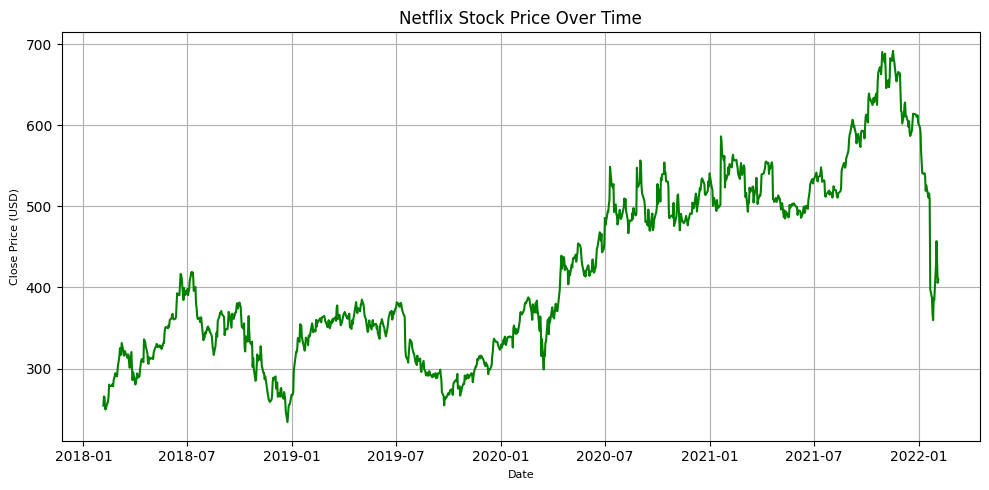

In [38]:
import seaborn as sns
df_1 = df.withColumn("Date", col("Date").cast("timestamp"))
pandas_df = df_1.toPandas()

plt.figure(figsize=(10, 5))
sns.lineplot(x = "Date", y = "Close", data=pandas_df, color='green')
plt.title('Netflix Stock Price Over Time', fontsize=12)
plt.xlabel('Date', fontsize=8)
plt.ylabel('Close Price (USD)', fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()

This is a line graph representing the closing stock price of Netflix over time, beginning from January 2018 until January 2022.

- Target: Understanding the long-term trend of Netflix stock price over the years, identifying periods of significant growh and decline.

- Reason: Evaluate the overall performance of the stock, helping to identify important milestones such as price highs and lows.

  + Strong growth trend in the period 2018-2022. 
  + Strong fluctuations during the Covid-19 period (2019-2020).
  + The drop in price during 2021-2022 suggests a possible turning point in the stock's performance.

### Correlation (Heatmap) between variables

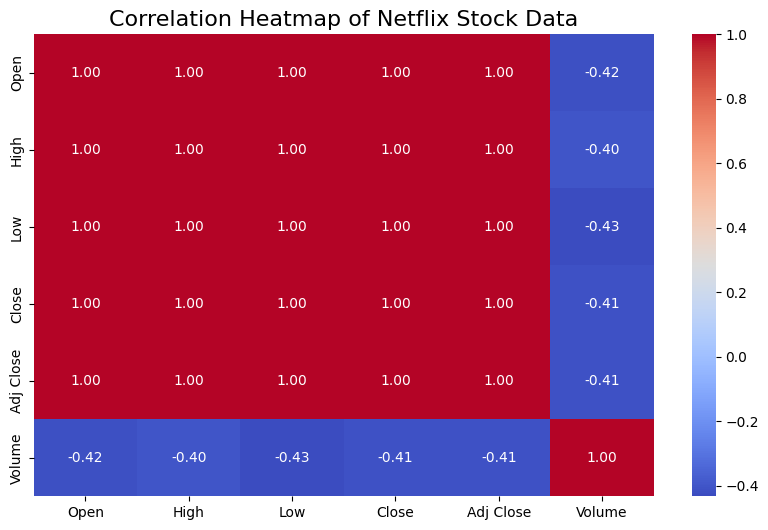

In [39]:
# Correlation heatmap of numeric features only
corr_matrix = pandas_df[['Open', 'High', 'Low', 'Close','Adj Close', 'Volume']].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Netflix Stock Data', fontsize=16)
plt.show()

- Correlation HeatMap: Helps in feature selection by eliminating highly correlated variables (avoiding multicollinearity).

- Magnitude of Correlation: The correlation coefficients are very close to 1 (positive correlation) or -1 (negative correlation), indicating a strong linear relationship between the features.

- Key Observations:

  + "Open, High, Low, Close, Adj Close" are highly correlated with each other.

  + "Volume" has a negative correlation with other features. This means that when the stock price increases, the volume tends to decrease, and vice versa.

### Boxplot distributes closing prices by year

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_6864\3311405778.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Year', y='Close', data=pandas_df, palette='viridis')


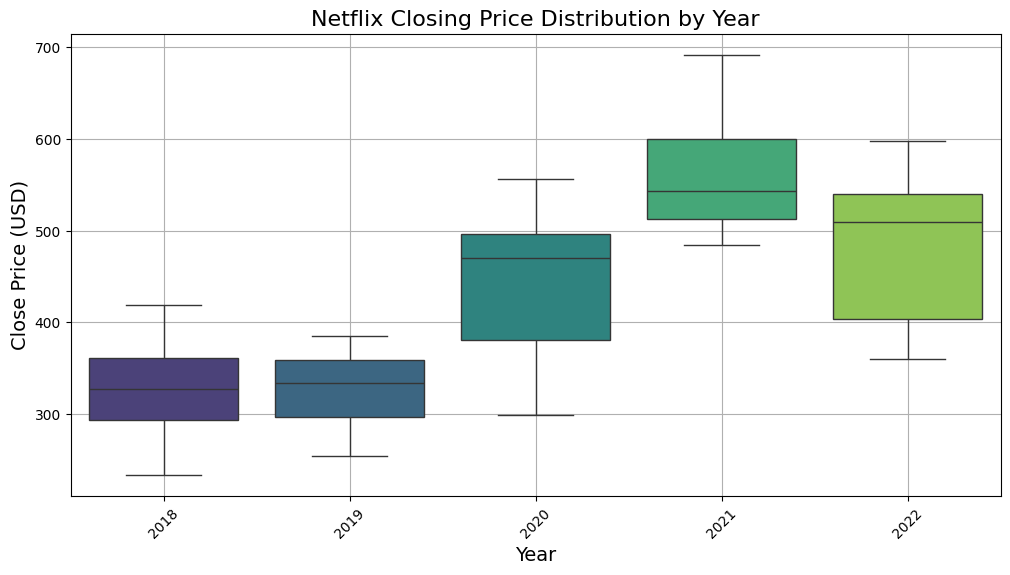

In [40]:
pandas_df['Year'] = pandas_df['Date'].dt.year

plt.figure(figsize=(12, 6))
sns.boxplot(x='Year', y='Close', data=pandas_df, palette='viridis')
plt.title('Netflix Closing Price Distribution by Year', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Close Price (USD)', fontsize=14)
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

The box plot shows the distribution of Netflix closing prices by year from 2018 to 2022.

- 2018: The median closing price is around $340, with a range from $240 to $420.
- 2019: The median closing price is around $350, with a range from $260 to $380.
- 2020: The median closing price is around $480, with a range from $300 to $560.
- 2021: The median closing price is around $540, with a range from $490 to $680.
- 2022: The median closing price is around $520, with a range from $400 to $600.

=> Overall, the box plot shows that Netflix closing prices have generally increased over the years, with the median price rising each year. The range of prices also seems to be increasing, with more volatility in recent years.

### Volume trading symbol over time

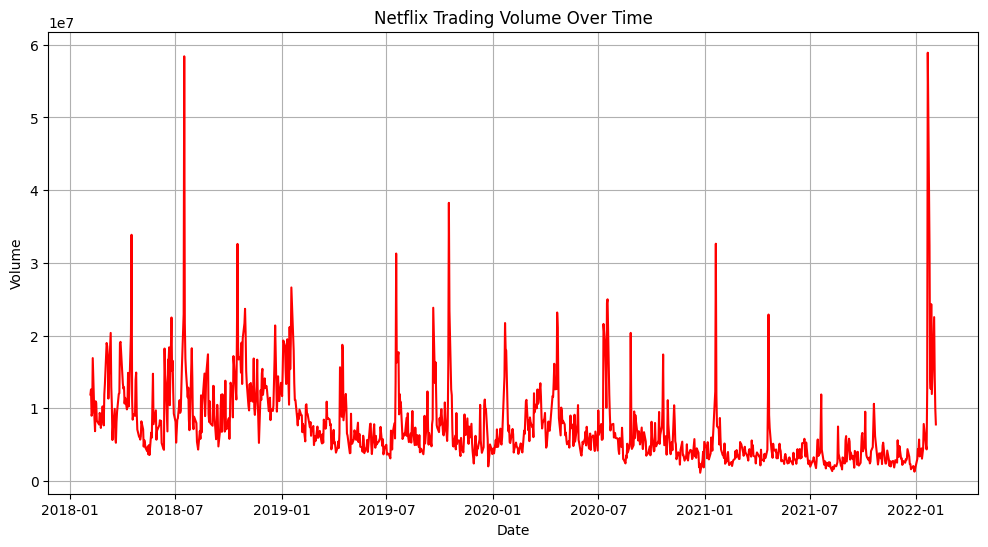

In [41]:
plt.figure(figsize=(12, 6))
sns.lineplot(x="Date", y="Volume", data=pandas_df, color="r")
plt.title("Netflix Trading Volume Over Time")
plt.xlabel("Date")
plt.ylabel("Volume")
plt.grid(True)
plt.show()

- Purpose: Analyze the relationship between trading volume and price volatility.

- Reason for selection: High trading volume is often accompanied by strong price volatility (e.g., company news, market events).

- Key observation:
   + The trading volume fluctuates significantly over time, showing high peaks and troughs.

   + High peaks: Several distinct spikes in trading volume suggest major events or announcements impacting the stock.
"
   + Market Volatility: The fluctuations in trading volume indicate significant market volatility around Netfli



# 3. Feature Engineering

### Features to Create
- Moving Average (MA): Average price over a period of time
- Relative Strength Index (RSI): Measures the momentum of the stock
- Stochastic Oscillator (Stoch): Identifies overbought and oversold conditions
- Bollinger Bands: Price volatility bands based on standard deviation
- Rate of Change (ROC): The rate of price change over a period of time

#### Moving Average (MA)

In [ ]:
# Moving Averages (SMA and EMA)
window_10d = Window.orderBy("Date").rowsBetween(-9, 0)  # 10 days for short term transaction
window_50d = Window.orderBy("Date").rowsBetween(-49, 0)  # 50 days for long term transaction

# SMA: Simple Moving Average of closing prices over a specific period
df = df.withColumn("10_day_SMA", avg(col("Close")).over(window_10d))
df = df.withColumn("50_day_SMA", avg(col("Close")).over(window_50d))

# EMA: 
# Exponential Moving Average (EMA 12 days)
n = 20
alpha = 2 / (n + 1)
ema_expr = """
    ROUND(
        SUM(Close * POW({}, 
        CAST(row_number() OVER (ORDER BY Date) AS INT))) 
        OVER (ORDER BY Date) / 
        SUM(POW({}, CAST(row_number() 
        OVER (ORDER BY Date) AS INT))) 
        OVER (ORDER BY Date)) 
    """.format(1 - alpha, 1 - alpha)
    
df = df.withColumn("20_day_EMA", expr(ema_expr))

print("\nAfter calculating Moving Averages:")
df.select("Date", "Close","10_day_SMA", "50_day_SMA", "20_day_EMA").show(5)


After calculating Moving Averages:
+----------+----------+------------------+------------------+----------+
|      Date|     Close|        10_day_SMA|        50_day_SMA|20_day_EMA|
+----------+----------+------------------+------------------+----------+
|2018-02-05|254.259995|        254.259995|        254.259995|     254.0|
|2018-02-06|265.720001|        259.989998|        259.989998|     260.0|
|2018-02-07|264.559998| 261.5133313333333| 261.5133313333333|     261.0|
|2018-02-08|250.100006|258.65999999999997|258.65999999999997|     259.0|
|2018-02-09|249.470001|256.82200019999993|256.82200019999993|     257.0|
+----------+----------+------------------+------------------+----------+
only showing top 5 rows



### Relative Strength Index (RSI)

In [ ]:
# RSI 14 days
window_spec_14d = Window.orderBy("Date").rowsBetween(-13, 0)

# Calculate price change
df = df.withColumn("Price_Change", col("Close") - lag(col("Close"), 1).over(Window.orderBy("Date")))

# Determine Gain and Loss days
df = df.withColumn("Gain", when(col("Price_Change") > 0, col("Price_Change")).otherwise(0))
df = df.withColumn("Loss", when(col("Price_Change") < 0, -col("Price_Change")).otherwise(0))

# Calculate average Gain/Loss
df = df.withColumn("Avg_Gain", avg(col("Gain")).over(window_spec_14d))
df = df.withColumn("Avg_Loss", avg(col("Loss")).over(window_spec_14d))

# Calculate RS and RSI
df = df.withColumn("RS", col("Avg_Gain") / col("Avg_Loss"))
df = df.withColumn("RSI", 100 - (100 / (1 + col("RS"))))

# Display results
print("\nAfter calculating RSI:")
df.select("Date", "Close", "RSI").show(5)


After calculating RSI:
+----------+----------+-----------------+
|      Date|     Close|              RSI|
+----------+----------+-----------------+
|2018-02-05|254.259995|             NULL|
|2018-02-06|265.720001|             NULL|
|2018-02-07|264.559998| 90.8082236708388|
|2018-02-08|250.100006|42.31907524671068|
|2018-02-09|249.470001|41.35692356039187|
+----------+----------+-----------------+
only showing top 5 rows



In [44]:
from pyspark.sql.functions import min, max, stddev

# Tính Stochastic Oscillator
window_stoch = Window.orderBy("Date").rowsBetween(-13, 0)
window_3d = Window.orderBy("Date").rowsBetween(-2, 0)

df = df.withColumn("Low_14", min(col("Low")).over(window_stoch))  
df = df.withColumn("High_14", max(col("High")).over(window_stoch)) 
df = df.withColumn("%K", ((col("Close") - col("Low_14")) / (col("High_14") - col("Low_14"))) * 100)
df = df.withColumn("%D", avg(col("%K")).over(window_3d))

# Hiển thị kết quả
print("\nAfter calculating Stochastic Oscillator:")
df.select("Date", "Close","Low_14", "High_14", "%K", "%D").show(5)


After calculating Stochastic Oscillator:
+-------------------+----------+----------+----------+------------------+------------------+
|               Date|     Close|    Low_14|   High_14|                %K|                %D|
+-------------------+----------+----------+----------+------------------+------------------+
|2018-02-05 00:00:00|254.259995|250.029999|267.899994|23.670941150235368|23.670941150235368|
|2018-02-06 00:00:00|265.720001|     245.0|267.899994| 90.48037741843964|57.075659284337505|
|2018-02-07 00:00:00|264.559998|     245.0|272.450012| 71.25679216460816| 61.80270357776106|
|2018-02-08 00:00:00|250.100006|     245.0|272.450012|18.579248708525174|60.105472763857655|
|2018-02-09 00:00:00|249.470001|236.110001|272.450012| 36.76388540443751| 42.19997542585694|
+-------------------+----------+----------+----------+------------------+------------------+
only showing top 5 rows



In [ ]:
# Calculate Bollinger Bands
df = df.withColumn("14_day_BB", stddev("Close").over(window_spec_14d))
df = df.withColumn("Upper_Band", col("20_day_SMA") + (col("20_day_STD") * 2))
df = df.withColumn("Lower_Band", col("20_day_SMA") - (col("20_day_STD") * 2))

print("\nAfter calculating Bollinger Bands:")
df.select("Date", "Close", "Upper_Band", "Lower_Band").show(5)


After calculating Bollinger Bands:
+-------------------+----------+-----------------+------------------+
|               Date|     Close|       Upper_Band|        Lower_Band|
+-------------------+----------+-----------------+------------------+
|2018-02-05 00:00:00|254.259995|             NULL|              NULL|
|2018-02-06 00:00:00|265.720001|276.1968939100771|243.78310208992295|
|2018-02-07 00:00:00|264.559998|274.1299184650964|248.89674420157024|
|2018-02-08 00:00:00|250.100006|274.0347469052368| 243.2852530947632|
|2018-02-09 00:00:00|249.470001|272.4697475489338| 241.1742528510661|
+-------------------+----------+-----------------+------------------+
only showing top 5 rows



In [46]:
# Another Features
df = df.withColumn("Daily_Volatility", col("High") - col("Low"))
df = df.withColumn("Close_Open_Ratio", col("Close")/col("Open"))

window_30d = Window.orderBy("Date").rowsBetween(-29, 0)
df = df.withColumn("30_day_Avg_Volume", avg("Volume").over(window_30d))

print("\nAfter additional features:")
df.select("Date", "Daily_Volatility", "Close_Open_Ratio", "30_day_Avg_Volume").show(5)


After additional features:
+-------------------+------------------+------------------+-----------------+
|               Date|  Daily_Volatility|  Close_Open_Ratio|30_day_Avg_Volume|
+-------------------+------------------+------------------+-----------------+
|2018-02-05 00:00:00| 17.86999499999999|0.9704579961832062|        1.18961E7|
|2018-02-06 00:00:00|21.700012000000015|1.0727493105298667|       1.224595E7|
|2018-02-07 00:00:00| 8.120024999999998|0.9924225782185216|        1.11578E7|
|2018-02-08 00:00:00|17.619995000000017|0.9364236115527442|      1.0695025E7|
|2018-02-09 00:00:00|19.690001999999993|0.9827456966851519|        1.19374E7|
+-------------------+------------------+------------------+-----------------+
only showing top 5 rows



In [47]:
#Điền giá trị NA bằng forward fill
from pyspark.sql.functions import last
for column in df.columns:
    df = df.withColumn(column, last(col(column), ignorenulls=True).over(Window.orderBy("Date")))

# Hiển thị kết quả
print("\nAfter handling missing values:")
df.select("Date", "RSI", "%K", "%D").show(5)


After handling missing values:
+-------------------+-------------------+------------------+------------------+
|               Date|                RSI|                %K|                %D|
+-------------------+-------------------+------------------+------------------+
|2018-02-05 00:00:00|               NULL|23.670941150235368|23.670941150235368|
|2018-02-06 00:00:00|               NULL| 90.48037741843964|57.075659284337505|
|2018-02-07 00:00:00| 111.26216176830256| 71.25679216460816| 61.80270357776106|
|2018-02-08 00:00:00|-275.48164189857306|18.579248708525174|60.105472763857655|
|2018-02-09 00:00:00| -239.2488591843748| 36.76388540443751| 42.19997542585694|
+-------------------+-------------------+------------------+------------------+
only showing top 5 rows



In [48]:
#Chọn các đặc trưng quan trọng
final_features = [
    "Date",
    "Close",
    "7_day_SMA",
    "20_day_SMA",
    "12_day_EMA",
    "RSI",
    "%K",
    "%D",
    "Upper_Band",
    "Lower_Band",
    "Daily_Volatility",
    "Close_Open_Ratio",
    "30_day_Avg_Volume"
]

df_final = df.select(final_features)

print("\nFinal feature set:")
df_final.show(5)


Final feature set:
+-------------------+----------+------------------+------------------+----------+-------------------+------------------+------------------+-----------------+------------------+------------------+------------------+-----------------+
|               Date|     Close|         7_day_SMA|        20_day_SMA|12_day_EMA|                RSI|                %K|                %D|       Upper_Band|        Lower_Band|  Daily_Volatility|  Close_Open_Ratio|30_day_Avg_Volume|
+-------------------+----------+------------------+------------------+----------+-------------------+------------------+------------------+-----------------+------------------+------------------+------------------+-----------------+
|2018-02-05 00:00:00|254.259995|        254.259995|        254.259995|     254.0|               NULL|23.670941150235368|23.670941150235368|             NULL|              NULL| 17.86999499999999|0.9704579961832062|        1.18961E7|
|2018-02-06 00:00:00|265.720001|        259.9899